In [1]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 7.2 MB/s eta 0:00:00


In [2]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


# **Importing required libraries**

In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import unicodedata
from tqdm.auto import tqdm
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from tqdm.auto import tqdm
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# Dataset loading
CSV_PATH = "esg_documents_for_dax_companies.csv"

df = pd.read_csv(
    CSV_PATH,
    sep="|",
    dtype=str,
    na_values=["", "NA", "NaN", None],
    keep_default_na=False,
    low_memory=False,
)

print(df.shape)
df.head()

(11548, 11)


,Unnamed: 0,company,content,datatype,date,domain,esg_topics,internal,symbol,title,url
0,2,Beiersdorf AG,Sustainability Highlight Report CARE BEYOND SK...,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN
1,3,Deutsche Telekom AG,Corporate Responsibility Report 2021 2 Content...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'Iso50001', 'GlobalWarming', ...",1,DTE,DeutscheTelekomAG Sustainability Report 2021,NaN
2,5,Vonovia SE,VONOVIA SE SUSTAINABILITY REPORT 2021 =For a S...,sustainability_report,2021-03-31,NaN,"['Whistleblowing', 'DataSecurity', 'Vaccine', ...",1,VNA,VonoviaSE Sustainability Report 2021,NaN
3,6,Merck KGaA,Sustainability Report 2021 TABLE OF CONTENTS S...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'DataMisuse', 'DrugResistance...",1,MRK,MerckKGaA Sustainability Report 2021,NaN
4,9,MTU,Our ideas and concepts FOR A SUSTAINABLE FUTUR...,sustainability_report,2020-03-31,NaN,"['WorkLifeBalance', 'Corruption', 'AirQuality'...",1,MTX,MTUAeroEngines Sustainability Report 2020,NaN


In [ ]:
# Checking data shape
print("Shape:", df.shape)

Shape: (11548, 11)


In [ ]:
# Dataset description
df.describe()

,Unnamed: 0,company,content,datatype,date,domain,esg_topics,internal,symbol,title,url
count,11547,11547,11547,11392,11547,11456,11547,11547,11547,11547,11456
unique,11456,40,11177,9,833,266,5391,2,39,10960,11134
top,131,Porsche,132 the event of dismissal/termination of cont...,general,2021-10-03,marketscreener,[],0,PAH3,Infineon Technologies: Remuneration Report,https://www.marketscreener.com/quote/stock/INF...
freq,2,504,12,4203,221,1938,614,11456,504,12,12


# **Data preprocessing**

In [ ]:
# Checking and Handling Missing Values
# Droping rows with missing or empty 'content'
before = len(df)
df = df.dropna(subset=["content"])
df = df[df["content"].str.strip().str.len() > 0]
print(f"Dropped {before - len(df)} rows with missing/empty content.")

Dropped 1 rows with missing/empty content.


In [ ]:
# Checking and Removing Duplicates
before = len(df)
df = df.drop_duplicates(subset=["company", "content"])
print(f"Dropped {before - len(df)} duplicate rows based on (company, content).")

df = df.reset_index(drop=True)

Dropped 62 duplicate rows based on (company, content).


In [ ]:
# Cleaning Text data
def clean_text(s: str) -> str:
    s = str(s)
    s = unicodedata.normalize("NFKC", s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"\S+@\S+", " ", s)
    s = re.sub(r"[^a-zA-Z\s]", " ", s)
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

tqdm.pandas(desc="cleaning")
df["clean_text"] = df["content"].progress_apply(clean_text)

cleaning:   0%|          | 0/11485 [00:00<?, ?it/s]

In [ ]:
# Tokenization & Lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
# Increase the max_length to handle potentially long documents
nlp.max_length = 3_000_000

tokens_list, lemmas_list = [], []

# Process the text in batches to reduce memory usage
for doc in tqdm(nlp.pipe(df["clean_text"].tolist(), batch_size=500), total=len(df), desc="spaCy"):
    tokens = [t.text for t in doc if t.is_alpha and not t.is_stop]
    lemmas = [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]
    tokens_list.append(tokens)
    lemmas_list.append(lemmas)


df["tokens"] = tokens_list
df["lemmas"] = lemmas_list
df["num_tokens"] = df["tokens"].map(len)

spaCy:   0%|          | 0/11485 [00:00<?, ?it/s]

In [ ]:
# Filtering Very Short Docs
min_tokens = 10
before = len(df)
df = df[df["num_tokens"] >= min_tokens].reset_index(drop=True)
print(f"Removed {before - len(df)} very short docs (<{min_tokens} tokens).")

Removed 3 very short docs (<10 tokens).


In [ ]:
# Saving Preprocessed Dataset
df.to_parquet("esg_preprocessed.parquet", index=False)
print("Preprocessing complete. Saved as 'esg_preprocessed.parquet'.")

Preprocessing complete. Saved as 'esg_preprocessed.parquet'.


# **Exploratory Data Analysis**

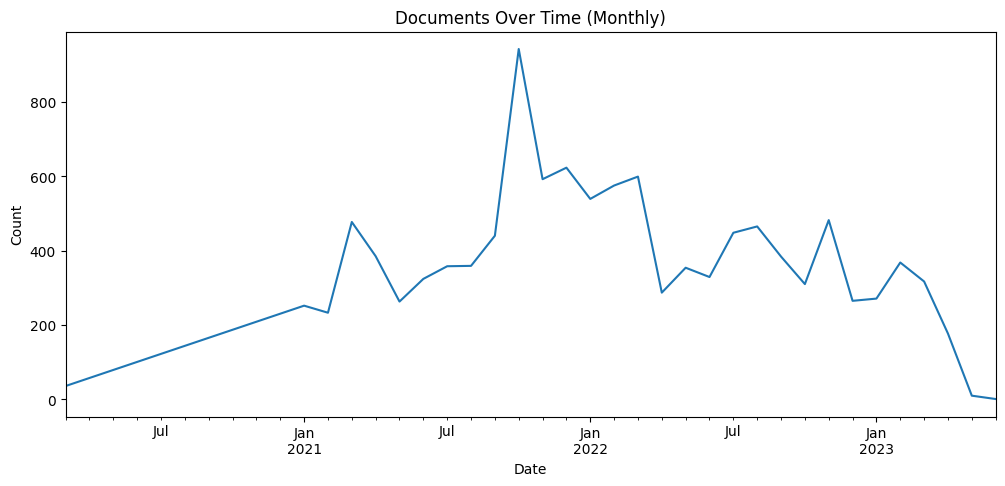

In [ ]:
# Document Trend Over Time
df["date"] = pd.to_datetime(df["date"], errors="coerce")
docs_over_time = df.groupby(df["date"].dt.to_period("M")).size()

docs_over_time.plot(figsize=(12,5))
plt.title("Documents Over Time (Monthly)")
plt.ylabel("Count")
plt.xlabel("Date")
plt.show()

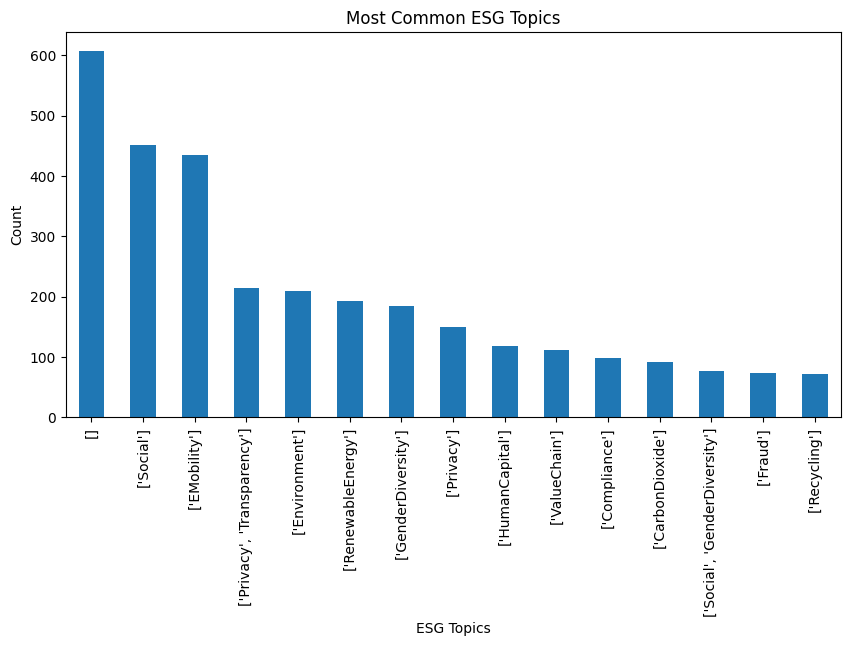

In [ ]:
# Distribution of ESG Topics
topic_counts = df["esg_topics"].value_counts().head(15)
topic_counts.plot(kind="bar", figsize=(10,5))
plt.title("Most Common ESG Topics")
plt.ylabel("Count") # Change ylabel back for vertical bar chart
plt.xlabel("ESG Topics") # Change xlabel back for vertical bar chart
plt.xticks(rotation=90) # Rotate labels for better readability
plt.show()

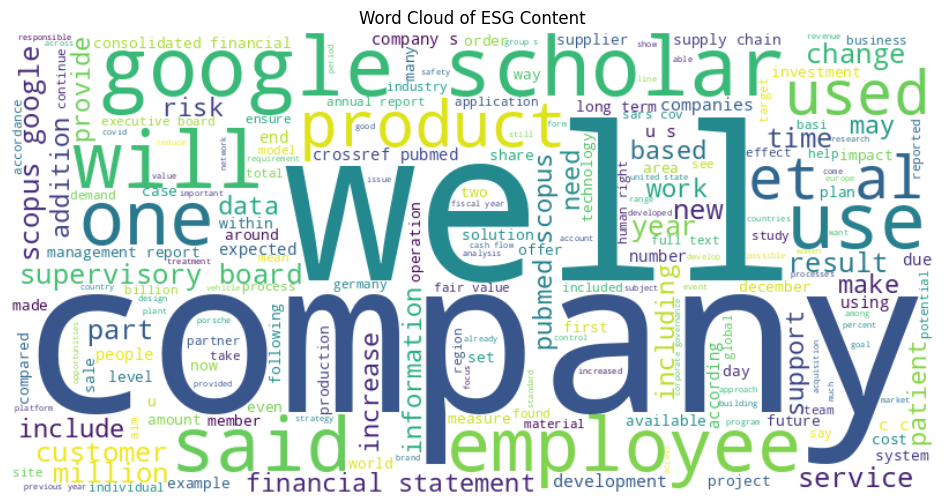

In [ ]:
# Top Words Cloud
text = " ".join(df["clean_text"].dropna().tolist())
wc = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of ESG Content")
plt.show()


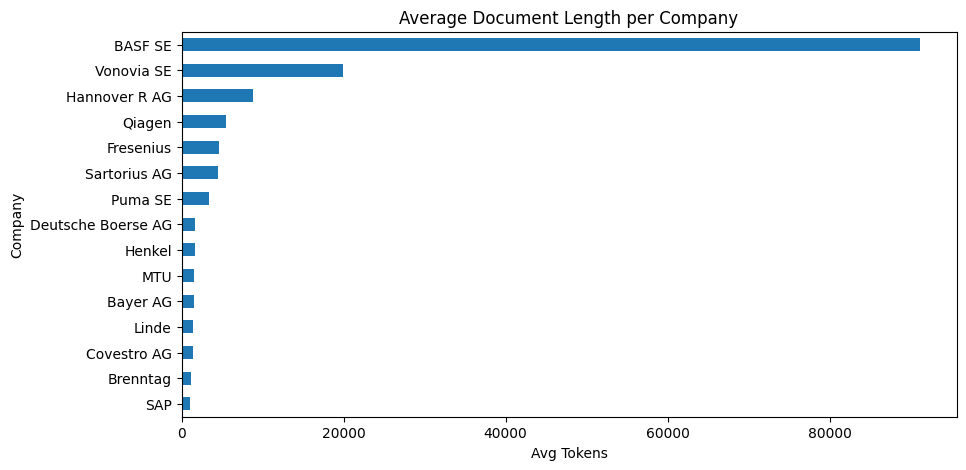

In [ ]:
# Token Count vs Company
avg_len_by_company = df.groupby("company")["num_tokens"].mean().sort_values(ascending=False).head(15)
avg_len_by_company.plot(kind="barh", figsize=(10, 5))
plt.title("Average Document Length per Company")
plt.xlabel("Avg Tokens")
plt.ylabel("Company")
plt.gca().invert_yaxis() # Invert y-axis to show the highest average length at the top
plt.show()

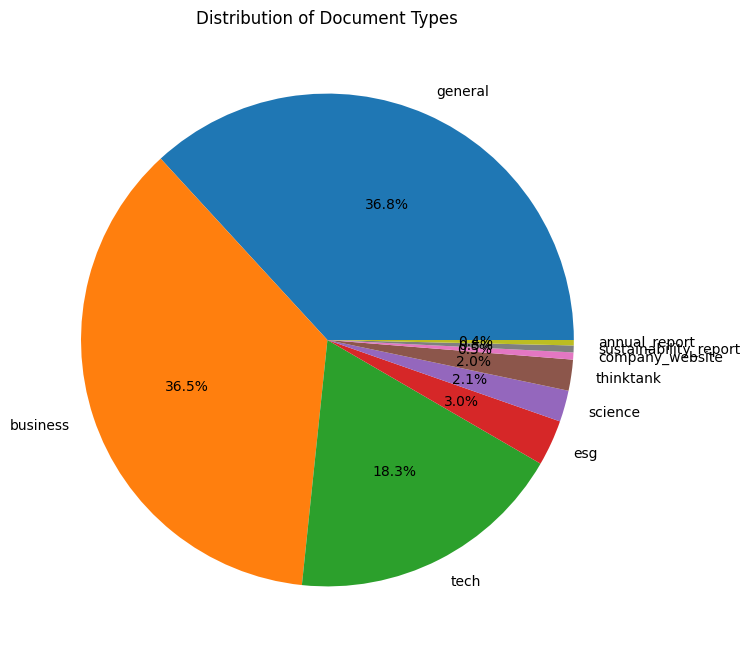

In [ ]:
# Datatype Distribution
df["datatype"].value_counts().plot(kind="bar", figsize=(8,4))
plt.title("Distribution of Document Types")
plt.ylabel("Count")
plt.show()

# **Natural Language Processing**

In [ ]:
# Topic Modeling with LDA
# Vectorization for LDA
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_counts = count_vectorizer.fit_transform(df["clean_text"])

# LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_counts)

# Displaying top words per topic
terms = count_vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    top_terms = [terms[i] for i in topic.argsort()[-10:]]
    print(f"Topic {idx+1}: {' | '.join(top_terms)}")

Topic 1: use | world | company | just | like | time | people | year | new | said
Topic 2: data | study | crossref | scopus | patients | al | et | pubmed | scholar | google
Topic 3: data | report | technology | new | growth | industry | energy | company | global | market
Topic 4: energy | sustainable | report | climate | emissions | group | business | employees | management | sustainability
Topic 5: business | statements | company | report | million | year | management | group | board | financial


In [ ]:
# Topic Modeling with BERTopic
topic_model = BERTopic(language="english", verbose=True)
topics, probs = topic_model.fit_transform(df["clean_text"])

# Showing top topics
topic_model.get_topic_info().head(10)


2025-09-01 09:20:18,014 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/359 [00:00<?, ?it/s]

2025-09-01 09:50:21,651 - BERTopic - Embedding - Completed ✓
2025-09-01 09:50:21,654 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-01 09:51:06,121 - BERTopic - Dimensionality - Completed ✓
2025-09-01 09:51:06,123 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-01 09:51:06,701 - BERTopic - Cluster - Completed ✓
2025-09-01 09:51:06,710 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-01 09:51:25,492 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,3521,-1_the_and_of_to,"[the, and, of, to, in, for, with, is, as, on]",[non financial group report n o n f i n a n c ...
1,0,273,0_imaging_august_radiology_ct,"[imaging, august, radiology, ct, ai, patient, ...",[while electronic medical record systems have ...
2,1,253,1_inflation_said_fed_bank,"[inflation, said, fed, bank, stocks, prices, i...",[banks and technology stocks lifted european s...
3,2,234,2_adidas_accessibility_shoes_you,"[adidas, accessibility, shoes, you, shoe, webs...",[brand lego x adidas model ultraboost dna rele...
4,3,166,3_hydrogen_green_energy_renewable,"[hydrogen, green, energy, renewable, gas, powe...",[green hydrogen using electrolyzers and wind a...
5,4,162,4_wind_offshore_rwe_turbine,"[wind, offshore, rwe, turbine, farm, turbines,...",[rwe is in the world for offshore wind and is ...
6,5,160,5_plastic_materials_plastics_recycled,"[plastic, materials, plastics, recycled, packa...",[june basf will present its journey to advance...
7,6,141,6_bmw_bmwgroup_remuneration_group,"[bmw, bmwgroup, remuneration, group, report, v...",[innovative mobility exciting trends for the f...
8,7,130,7_charging_electric_ev_vehicles,"[charging, electric, ev, vehicles, vehicle, ev...",[people create and sustain change unleash thei...
9,8,129,8_cancer_cells_patients_cell,"[cancer, cells, patients, cell, pdac, zol, tre...",[the methylthioadenosine phosphorylase mtap ge...


In [ ]:
# Sentiment Analysis (VADER + TextBlob)
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_optimized(text):
    # Ensuring text is a string, handling potential NaN or non-string types
    text = str(text)[:512]
    vader_score = analyzer.polarity_scores(text)["compound"]
    textblob_score = TextBlob(text).sentiment.polarity
    return vader_score, textblob_score

# Applying the optimized function
tqdm.pandas(desc="Analyzing Sentiment")
df[["vader_score", "textblob_score"]] = df["clean_text"].progress_apply(analyze_sentiment_optimized).tolist()


# Classifying sentiment (positive / neutral / negative)
df["sentiment_label"] = df["vader_score"].apply(
    lambda x: "positive" if x > 0.05 else ("negative" if x < -0.05 else "neutral")
)

display(df[["clean_text", "vader_score", "textblob_score", "sentiment_label"]].head())

Analyzing Sentiment:   0%|          | 0/11482 [00:00<?, ?it/s]

,clean_text,vader_score,textblob_score,sentiment_label
0,sustainability highlight report care beyond sk...,0.9661,0.500000,positive
1,corporate responsibility report contents this ...,0.4404,0.053423,positive
2,vonovia se sustainability report for a sustain...,0.2263,0.049206,positive
3,sustainability report table of contents strate...,0.6597,0.175000,positive
4,our ideas and concepts for a sustainable futur...,0.9595,0.200128,positive


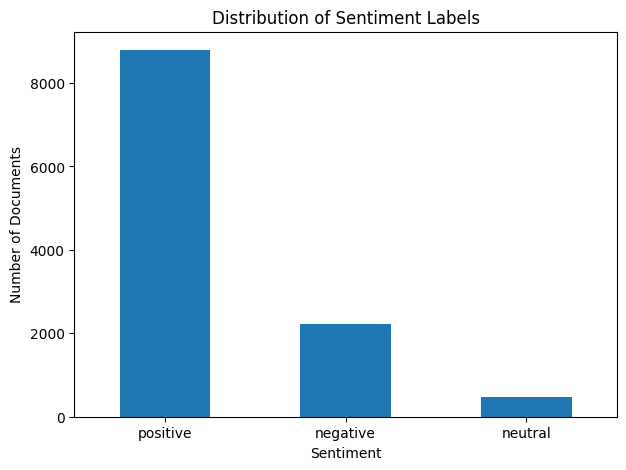

In [ ]:
# Visualising Sentiment Distribution
sentiment_counts = df["sentiment_label"].value_counts()

plt.figure(figsize=(7,5))
sentiment_counts.plot(kind="bar")
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Number of Documents")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Clustering (K-Means + Hierarchical)

# TF-IDF for clustering
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(df["clean_text"])

# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df["kmeans_cluster"] = kmeans.fit_predict(X_tfidf)

# Hierarchical clustering
hier = AgglomerativeClustering(n_clusters=5)
df["hier_cluster"] = hier.fit_predict(X_tfidf.toarray())


In [ ]:
# Validation (Cross-check Sentiment Consistency)
# Correlation between VADER & TextBlob
correlation = np.corrcoef(df["vader_score"], df["textblob_score"])[0,1]
print("Correlation between VADER and TextBlob sentiment scores:", correlation)

Correlation between VADER and TextBlob sentiment scores: 0.33556751873478147
